# Quantum Regression

Full credit and my thanks to the Qiskit community and Qiskit Machine Learning developers for providing the exercises shown in this workshop. Please refer to Qiskit website for documentation and support Qiskit Machine Learning on GitHub.

## Section 1 | Variational Quantum Computing

Variational quantum computing exploits the advantages of both classical computing and quantum computing. In a very general sense, we propose an initial solution to a problem, called an ansatz. In our case our ansatz will be an ansatz parametrised by a and b. We then prepare our qubits (the quantum equivalent of bits on a normal computer) and test how good the ansatz is, using the quantum computer. Testing the ansatz equates to minimising a cost function. We feed the result of this cost function back to the classical computer, and use some classical optimisers to improve on our ansatz, i.e. our initial guesses for a and b. We repeat this process until the ansatz is good enough within some tolerance.

![image](https://qiskit.org/textbook/ch-demos/images/vlinreg_circuit.png)



## Section 2 | Setup

In this section we import all the necessary libraries to train our model and visualize results further down the line.

* numpy:  is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.
* matplotlib: is a plotting library for the Python programming language and its numerical mathematics extension NumPy.
* qiskit: Qiskit is an open-source SDK for working with quantum computers at the level of pulses, circuits, and application modules.
* qiskit-machine-learning:  introduces fundamental computational building blocks - such as Quantum Kernels and Quantum Neural Networks - used in different applications, including classification and regression. On the one hand, this design is very easy to use and allows users to rapidly prototype a first model without deep quantum computing knowledge.

Afterwards, we will:
1. Create the Quantum Instance that will enable us to access a quantum computer simulator.
2. Create a callback function to plot the training results.
3. Create a dummy dataset to start our feature engineering.

In [20]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

algorithm_globals.random_seed = 42

In [21]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

In [22]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

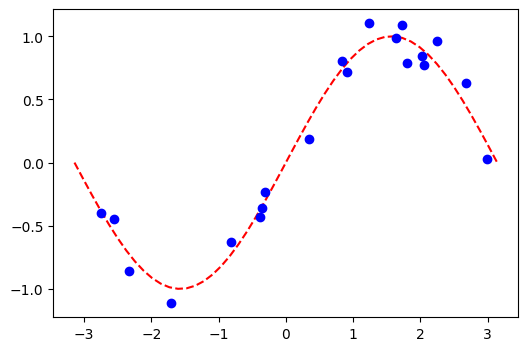

In [23]:
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
X_ = np.linspace(lb, ub, num=50).reshape(50, 1)
f = lambda x: np.sin(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X[:, 0]) + eps * (2 * algorithm_globals.random.random(num_samples) - 1)

plt.plot(X_, f(X_), "r--")
plt.plot(X, y, "bo")
plt.show()

## Section 2 | Quantum Regressor

In this section we will focus on simple feature engineering and creating a regressor neural network with 2 layers. The values that will result from each training epoch will be stored in an array which can be used to display the training results using the function to plot data we created in the previous section.

Now, let's talk about a Neural Networks and the model we will create. NNs are a type of Machine Learning algorithm inspired by the human brain, neurons to be specific. Neural networks have unit cells are connected and arranged in layers such that the inputs of one cell is the output of the previous one. The class **Neural Network Regressor** is based on Scikit-Learn methods for regression and extends RegressorMixin.
* Neural Network: **Two Layer Quantum Neural Network** consisting of a feature map, a ansatz, and an observable.
* Loss: **Squared Error** is a loss function that can be used in the learning setting in which we are
predicting a real-valued variable y given an input variable x.
* Optimizer: We will use the optimizer function **L_BFGS_B** (Limited-memory BFGS Bound optimizer). The target goal of Limited-memory Broyden-Fletcher-Goldfarb-Shanno Bound (L-BFGS-B) is to minimize the value of a differentiable scalar function . This optimizer is a quasi-Newton method, meaning that, in contrast to Newtons’s method, it does not require ’s Hessian (the matrix of ’s second derivatives) when attempting to compute ’s minimum value.
* Callback fn: we will use the graph function to show results of each epoch.

In [24]:
# construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# construct simple ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

# construct QNN
regression_opflow_qnn = TwoLayerQNN(1, feature_map, ansatz, quantum_instance=quantum_instance)

In [25]:
# construct the regressor from the neural network
regressor = NeuralNetworkRegressor(
    neural_network=regression_opflow_qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(),
    callback=callback_graph,
)

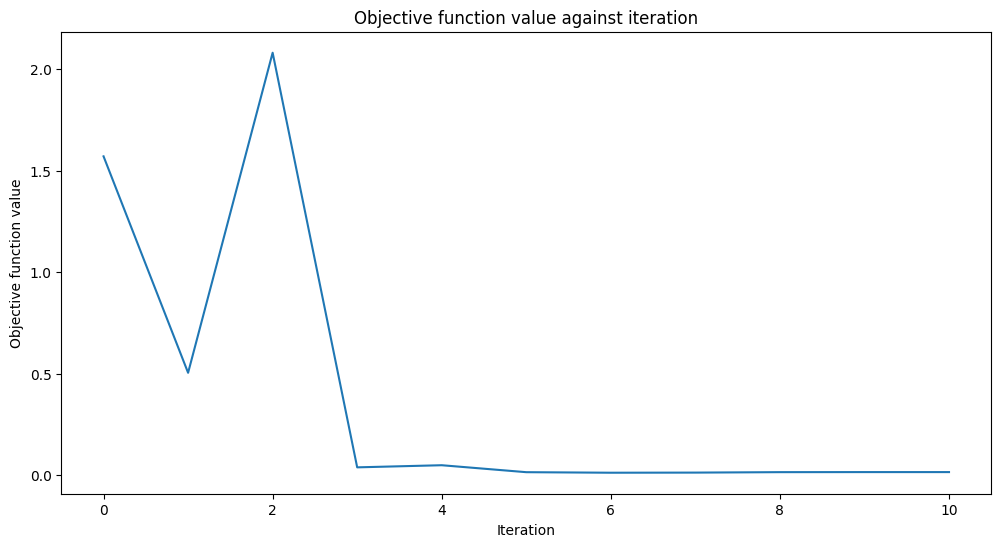

0.976059194599413

In [26]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score the result
regressor.score(X, y)

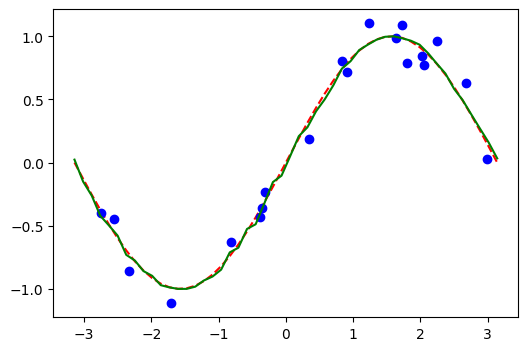

In [27]:
# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = regressor.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()

In [28]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(),
    quantum_instance=quantum_instance,
    callback=callback_graph,
)

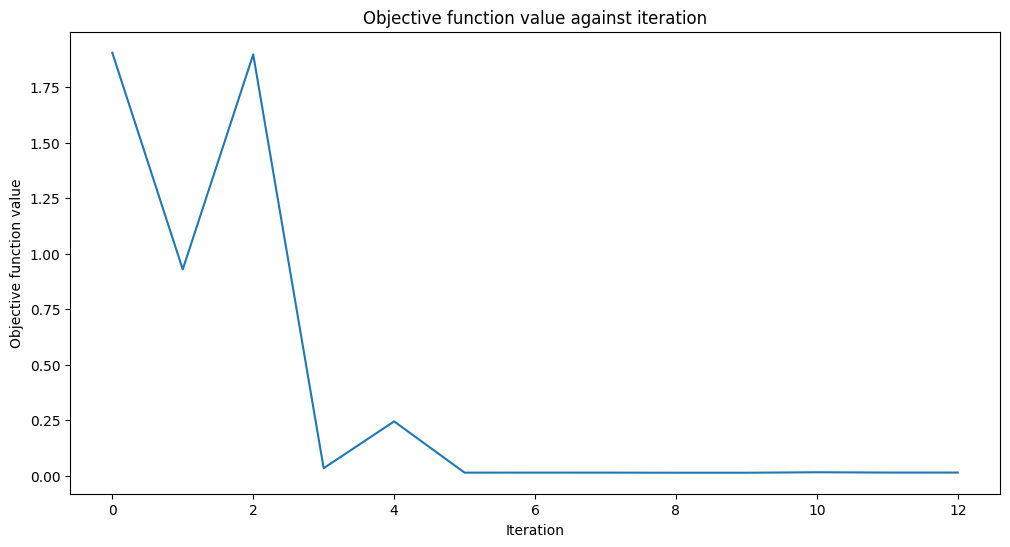

0.9619781803551648

In [29]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score result
vqr.score(X, y)

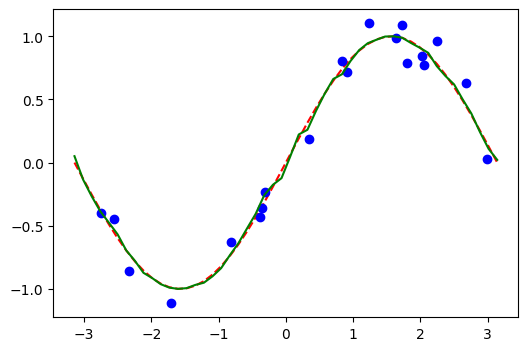

In [30]:
# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = vqr.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()